In [30]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [31]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
print(df_weekly_sum.head())
print(df_weekly_sum.shape)
# print(list(df_weekly_sum['Location'].unique()))
# Assuming the DataFrame is named df
south_africa_freq = df_weekly_sum[df_weekly_sum['Location'].str.contains("South Africa")]['Freq']

# Display the resulting DataFrame
print(south_africa_freq.shape)


  Variant                   Date                         Location  Freq
0   Alpha  2019-12-30/2020-01-05  Africa / South Africa / Gauteng     1
1   Alpha  2019-12-30/2020-01-05            Asia / India / Kerala     5
2   Alpha  2019-12-30/2020-01-05        Asia / India / Tamil Nadu     1
3   Alpha  2019-12-30/2020-01-05                          Austria     4
4   Alpha  2019-12-30/2020-01-05                  Europe / Cyprus    21
(83737, 4)
(2292,)


In [32]:
#     # Filter the dataset for the current country
# country_data = df_weekly_sum[df_weekly_sum['Location'] == "USA"]
    
#     # # Filter the country to be merged with the country_data
#     # country_data1 = dataset[dataset['Location'] == country1]
    
#     # Get the "Freq" column values for the current country
# country_freq = country_data['Freq']
# country_freq

In [33]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
# def transform_ratio(clade_1, clade_2):
#     return np.log10(clade_1/clade_2)

def transform_ratio(clade_1, clade_2):
    clade_1 = np.where(clade_1 <= 0, np.nan, clade_1) #negative values are replaced with zeroes as the log of zero returns math error
    clade_2 = np.where(clade_2 <= 0, np.nan, clade_2)
    return clade_1 / clade_2

#     ratio = clade_1 / clade_2
#     with np.errstate(divide='ignore', invalid='ignore'):
#         result = np.log10(ratio)
#     return result


def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [59]:
def scatterplot(country, dataset, start, end, variant): #, sigma = [0.1, 0.2, 0.5, 1, 1.5]):
    # Check if the 'SouthAfricaFreqAdded' column exists in the dataset
    if 'SouthAfricaFreqAdded' not in dataset.columns:
        # If it doesn't exist, create the column and set all values to False
        dataset['SouthAfricaFreqAdded'] = False

    # Get the mean frequency for South Africa
    south_africa_freq = dataset[dataset['Location'].str.contains("South Africa")]['Freq'].mean()
    print(f'South africa mean:{south_africa_freq}')
    # Filter the dataset for the current country
    country_data = dataset[dataset['Location'] == country]
    
    # Check if the South Africa frequency has already been added for this country
    if not dataset.loc[dataset['Location'] == country, 'SouthAfricaFreqAdded'].any():
        # If not added, add the South Africa frequency to the 'Freq' column for the current country
        dataset.loc[dataset['Location'] == country, 'Freq'] += south_africa_freq
        # Mark that the South Africa frequency has been added for this country
        dataset.loc[dataset['Location'] == country, 'SouthAfricaFreqAdded'] = True
    
#     # Filter the dataset for the current country
#     country_data = dataset[dataset['Location'] == country]
    
#     # Get the "Freq" column values for the current country
#     country_freq = country_data['Freq']
    
#     # Get the frequncy for the country to br merged -> "South Africa"
#     south_africa_freq = df_weekly_sum[df_weekly_sum['Location'].str.contains("South Africa")]['Freq'].mean()
#     print(south_africa_freq)
    
    '''
    # Calculate the standard deviation
    std_dev = np.std(country_freq)
    print(f"std_dev of {country}: {std_dev}")

    # Choose the appropriate sigma value based on the standard deviation
    if std_dev < 500:
        sigma = 0.1
    elif 500 <= std_dev < 10000:
        sigma = 0.2
    else:
        sigma = 1.5

    # Adding Gaussian noise to the last column
    mu = mu  # Mean of the Gaussian distribution
#     sigma = sigma  # Standard deviation of the Gaussian distribution
    '''
    
    # # Add noise to the last column
    # dataset['Freq'] += south_africa_freq
    # print(dataset.head())
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])
#     print(df_weekly.head())
    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
#     print(tmp.head())
    tmp.columns = ['0','1','2','3']
#     print(tmp.head())

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
#     print(df_weekly.head())
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
#     df_sum.to_csv(r'df_sum.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
    # print(print(df_.columns))
 

    #scatterplot of omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc = {'figure.figsize':(3,3)})
#     plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
    pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
    marker = ['.', '+', 'v', 'x','*']
    legend=[]
    c=0
    # Create a list to store the slope values and corresponding locations
    slope_values = []
    
#     for i in pango_compare:
#         if i != 'Omicron': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
#             mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['Omicron vs {0}'.format(i)][mask])
# #             print('test')
# #             print(slope)
# #             print(intercept)
#             slope_values.append((country, slope))  # Append tuple of location and slope value
#             print(f"Slope values: {slope_values}")
#             sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color = 'red')
#             # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
#         c+=1
      
    for i in pango_compare:
        if i != 'Omicron':
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
            if np.any(mask):
                slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
                print(f'P-value: {p_value}')
                slope_values.append((country, slope))
                sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
            else:
                print(f"No data available for Omicron vs {i}")
        c += 1
    '''
    #Save the slope values of corresponding countries to a CSV file
    # Define the file path to save the CSV
    csv_file = 'Omicron_Vs_delta_slope_values_countries_with_noise.csv'

    # Append the slope values to the CSV file
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
        writer.writerows(slope_values)  # Append the slope values

    print('Slope values saved to', csv_file)
    '''
    
#     plt.legend(loc='upper left', prop={'size': 11}, facecolor='white', fontsize = 8) 
    plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
    plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nLocation : {country}', fontsize=7.5)
    plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
    plt.rc('axes', labelsize=7.5)  # Adjust the label font size
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')  # Set plot background color to white
    

   
    # Add vertical bars for x-axis and y-axis without changing the range
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
 
    
#     #Save the figures to `omicron_vs_delta_regression_plots` folder
#     import os

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots_with_noise/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, country + "_regression_Omicron_vs_delta_with_noise.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.savefig(country+"_slope"+'.png')

South africa mean:15.965532286212914
['2022-03', '2022-04', '2022-05']
P-value: 6.068629406301078e-09


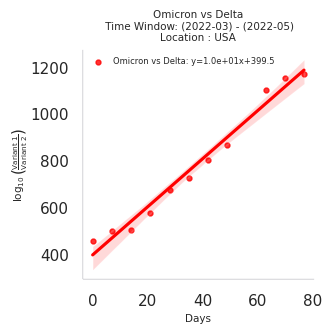

In [60]:
scatterplot('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variant = 'Delta')  #you can pass a list of variants to compare

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.04597957101566012


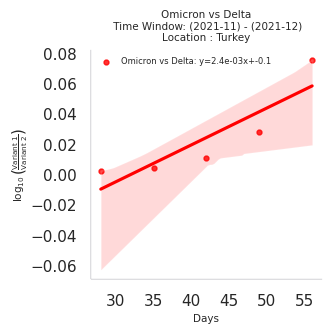

In [61]:
scatterplot('Turkey', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.00866899483993563


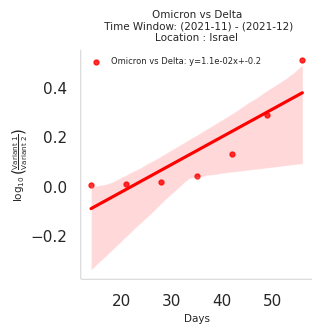

In [62]:
scatterplot('Israel', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.02496855595721161


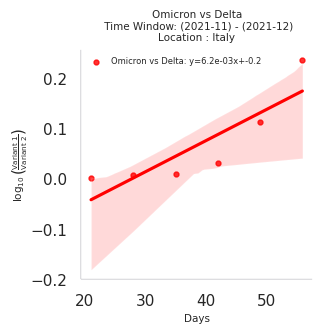

In [63]:
scatterplot('Italy', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.0018300014912555139


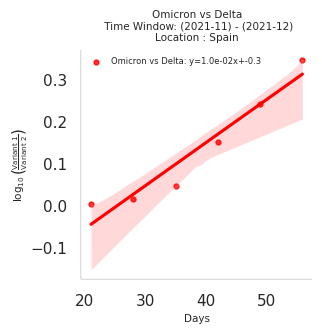

In [64]:
scatterplot('Spain', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.0022773742958002896


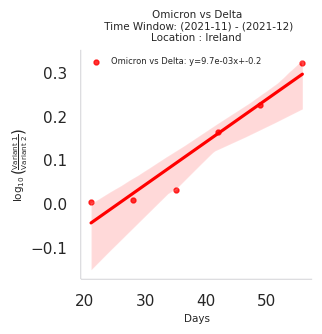

In [65]:
scatterplot('Ireland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.014599195423581283


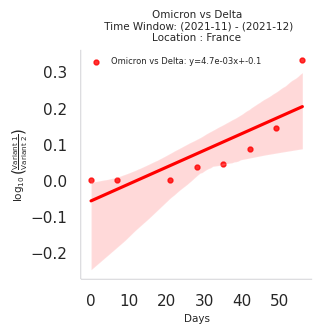

In [66]:
scatterplot('France', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-12', '2022-01']
P-value: 2.128821663779548e-05


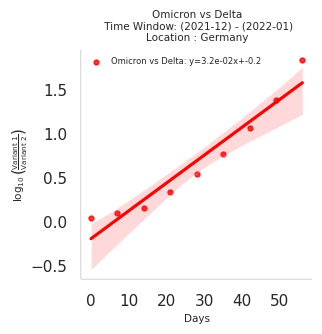

In [67]:
scatterplot('Germany', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta')

South africa mean:15.965532286212914
['2021-12', '2022-01']
P-value: 3.583729866611936e-06


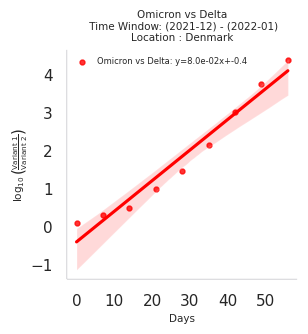

In [68]:
scatterplot('Denmark', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12', '2022-01']
P-value: 4.2866831050043105e-05


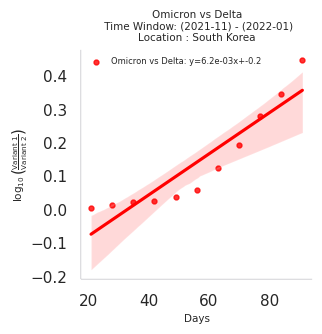

In [69]:
scatterplot('South Korea', df_weekly_sum, start = '2021-11', end = '2022-01', variant = 'Delta')

South africa mean:15.965532286212914
['2021-12', '2022-01']
P-value: 2.87859879680217e-05


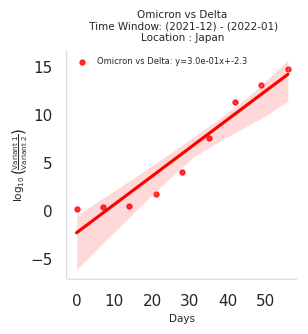

In [70]:
scatterplot('Japan', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.0018563579942776208


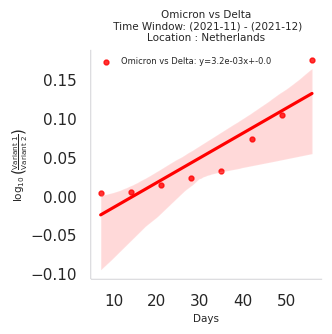

In [71]:
scatterplot('Netherlands', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-11', '2021-12']
P-value: 0.004556438400029863


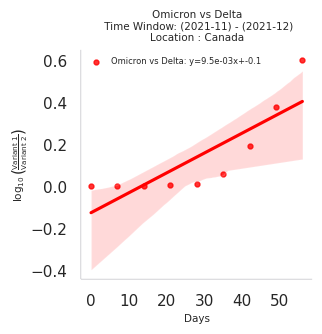

In [72]:
scatterplot('Canada', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta')

South africa mean:15.965532286212914
['2021-12', '2022-01']
P-value: 2.5463442890416453e-06


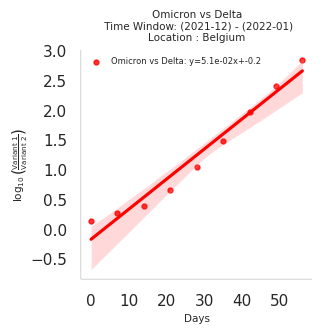

In [73]:
scatterplot('Belgium', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta')